In [32]:
from surprise import Dataset
import pandas as pd
from surprise import Dataset, Reader
from surprise import Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV
import pickle
import pyarrow.parquet as pq
import pyarrow as pa


In [2]:
df_games = pd.read_parquet('./data/steam_games22.parquet')
df_reviews = pd.read_parquet('./data/user_reviews.parquet')

In [3]:
df_reviews.head(1)

,user_id,item_id,helpful,recommend,sentiment_analysis,posted_year
0,76561197970982479,1250,No ratings yet,True,2,2011


In [4]:
df_games.head(1)

,app_name,price,item_id,developer,release_year,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,...,Photo Editing,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing
0,Lost Summoner Kitty,4.99,761140,Kotoshiro,2018,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [5]:
df = pd.merge(df_reviews[['item_id','user_id','recommend','sentiment_analysis']], df_games[['item_id','app_name']], left_on='item_id', right_on='item_id')


In [6]:
df

,item_id,user_id,recommend,sentiment_analysis,app_name
0,1250,76561197970982479,True,2,Killing Floor
1,1250,death-hunter,True,2,Killing Floor
2,1250,DJKamBer,True,0,Killing Floor
3,1250,diego9031,True,1,Killing Floor
4,1250,76561198081962345,True,1,Killing Floor
...,...,...,...,...,...
41609,367780,laislabonita75,True,2,Aero's Quest
41610,367780,evilindiegaming,True,2,Aero's Quest
41611,305920,laislabonita75,False,0,Another Perspective
41612,306040,Gamer0009,True,2,The Howler


In [8]:
for index, row in df.iterrows():
    if (row[2] == True) and (row[3] == 2):
        df.loc[index, 'rating'] = 5.0
        
    elif (row[2] == True) and (row[3] == 1):
        df.loc[index, 'rating'] = 4.0
        
    elif (row[2] == True) and (row[3] == 0):
        df.loc[index, 'rating'] = 3.0
        
    elif (row[2] == False) and (row[3] == 2):
        df.loc[index, 'rating'] = 2.0
        
    elif (row[2] == False) and (row[3] == 1):
        df.loc[index, 'rating'] = 1.0
        
    elif (row[2] == False) and (row[3] == 0):
        df.loc[index, 'rating'] = 0.0


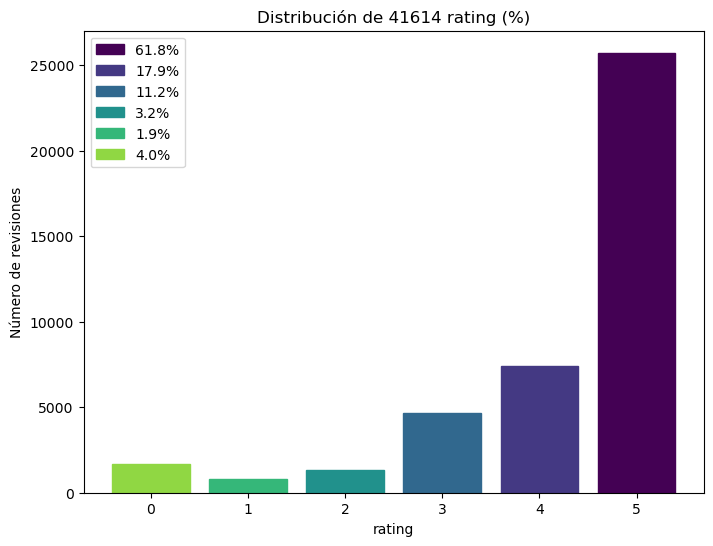

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Calcula la distribución de sentimientos
data = df['rating'].value_counts().sort_index(ascending=False)
percentage_data = (data / df.shape[0] * 100)


colors = plt.get_cmap('viridis')

# Crea la figura con Matplotlib
plt.figure(figsize=(8, 6))
bars = plt.bar(data.index, data.values)
plt.xlabel('rating')
plt.ylabel('Número de revisiones')
plt.title('Distribución de {} rating (%)'.format(df.shape[0]))


for i, (bar, v) in enumerate(zip(bars, percentage_data)):
    bar.set_color(colors(i / len(data)))
    bar.set_label('{:.1f}%'.format(v))


plt.legend(loc='upper left')
plt.show()

In [10]:
df.head()

,item_id,user_id,recommend,sentiment_analysis,app_name,rating
0,1250,76561197970982479,True,2,Killing Floor,5.0
1,1250,death-hunter,True,2,Killing Floor,5.0
2,1250,DJKamBer,True,0,Killing Floor,3.0
3,1250,diego9031,True,1,Killing Floor,4.0
4,1250,76561198081962345,True,1,Killing Floor,4.0


In [11]:
entrenar= df[['user_id','app_name','rating']]
entrenar

,user_id,app_name,rating
0,76561197970982479,Killing Floor,5.0
1,death-hunter,Killing Floor,5.0
2,DJKamBer,Killing Floor,3.0
3,diego9031,Killing Floor,4.0
4,76561198081962345,Killing Floor,4.0
...,...,...,...
41609,laislabonita75,Aero's Quest,5.0
41610,evilindiegaming,Aero's Quest,5.0
41611,laislabonita75,Another Perspective,0.0
41612,Gamer0009,The Howler,5.0


# SVD

In [13]:
# Definir un lector para el formato de tus datos
reader = Reader(rating_scale=(0, 5))  # Adaptar rating_scale a tus datos

# Cargar los datos con el lector
data = Dataset.load_from_df(entrenar, reader)

# Dividir el conjunto de datos en entrenamiento y prueba
train_set, test_set = train_test_split(data, test_size=0.25)  # Puedes ajustar el tamaño de prueba

# Seleccionar un algoritmo (por ejemplo, SVD) y entrenar el modelo
svd_algo = SVD(n_factors=50, n_epochs=30, biased=True, lr_all=0.005, reg_all=0.1, random_state=42)
svd_algo.fit(train_set)

# Realizar predicciones en el conjunto de prueba
test_pred = svd_algo.test(test_set)

print("SVD: Conjunto de Test")
accuracy.rmse(test_pred, verbose=True)

print("\n")

print("SVD: Conjunto de Entrenamiento")
training_pred= svd_algo.test(train_set.build_testset())
accuracy.rmse(training_pred, verbose=True)

SVD: Conjunto de Test
RMSE: 1.2206


SVD: Conjunto de Entrenamiento
RMSE: 0.8862


0.8861966941519387

- Ajuste Hiperparámetros SVD

In [14]:
#Ajuste de hiperparámetros
param_grid = {'n_factors': [5,50,100,120],'n_epochs': [5, 10,20,35], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs = -1)
gs.fit(data)



In [15]:
print("Mejor valor para RMSE:", gs.best_score['rmse'])

Mejor valor para RMSE: 1.22137018308139


In [16]:
print("Mejores hiperparámetros:", gs.best_params['rmse'])

Mejores hiperparámetros: {'n_factors': 120, 'n_epochs': 35, 'lr_all': 0.005, 'reg_all': 0.2}


In [17]:
mejor_svd= gs.best_estimator['rmse']

In [18]:
print("Validación cruzada del algoritmo SVD sobre 5 particiones")
cross_validate(mejor_svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Validación cruzada del algoritmo SVD sobre 5 particiones
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.2237  1.2107  1.2325  1.2228  1.2011  1.2265  1.2022  1.2206  1.2093  1.2075  1.2157  0.0103  
MAE (testset)     0.9036  0.8957  0.9093  0.8962  0.8884  0.9058  0.8869  0.8952  0.8944  0.8867  0.8962  0.0075  
Fit time          1.02    0.96    1.11    0.88    0.89    1.08    1.05    1.05    0.95    0.92    0.99    0.08    
Test time         0.02    0.02    0.02    0.02    0.02    0.03    0.02    0.03    0.02    0.02    0.02    0.00    


{'test_rmse': array([1.22370201, 1.21065222, 1.23248808, 1.2227788 , 1.20107745,
        1.22653547, 1.2021939 , 1.22060294, 1.20934331, 1.20745468]),
 'test_mae': array([0.90359837, 0.89565348, 0.90932812, 0.89621504, 0.8884198 ,
        0.90577106, 0.88685342, 0.89518139, 0.89442733, 0.88671562]),
 'fit_time': (1.0229198932647705,
  0.9635133743286133,
  1.114367961883545,
  0.8849799633026123,
  0.8874204158782959,
  1.0777642726898193,
  1.0493230819702148,
  1.0549266338348389,
  0.9488058090209961,
  0.9237565994262695),
 'test_time': (0.021673202514648438,
  0.019865751266479492,
  0.020549774169921875,
  0.019193172454833984,
  0.020154476165771484,
  0.02613067626953125,
  0.021024703979492188,
  0.025049924850463867,
  0.019192218780517578,
  0.02104353904724121)}

In [19]:

mejor_svd.fit(data.build_full_trainset())
# Realizar predicciones en el conjunto de prueba
test_pred = mejor_svd.test(test_set)

print("SVD: Conjunto de Test")
accuracy.rmse(test_pred, verbose=True)

print("\n")

print("SVD: Conjunto de Entrenamiento")
training_pred= mejor_svd.test(train_set.build_testset())
accuracy.rmse(training_pred, verbose=True)

SVD: Conjunto de Test
RMSE: 0.8473


SVD: Conjunto de Entrenamiento
RMSE: 0.8392


0.8392128669402595

In [20]:
mejor_svd.predict(uid='76561197970982479', iid='Killing Floor', r_ui=5.0)

Prediction(uid='76561197970982479', iid='Killing Floor', r_ui=5.0, est=4.495507742071554, details={'was_impossible': False})

In [21]:
entrenar.head(1)

,user_id,app_name,rating
0,76561197970982479,Killing Floor,5.0


In [22]:
def obtener_prediccion(row):
    user_id = row['user_id']
    item_id = row['item_id']
    prediccion = mejor_svd.predict(uid=user_id, iid=item_id)
    return prediccion.est

# Aplica la función de obtención de predicciones a cada fila del DataFrame
df['predicciones'] = df.apply(obtener_prediccion, axis=1)


In [23]:
df

,item_id,user_id,recommend,sentiment_analysis,app_name,rating,predicciones
0,1250,76561197970982479,True,2,Killing Floor,5.0,4.410874
1,1250,death-hunter,True,2,Killing Floor,5.0,4.496091
2,1250,DJKamBer,True,0,Killing Floor,3.0,4.308860
3,1250,diego9031,True,1,Killing Floor,4.0,4.237986
4,1250,76561198081962345,True,1,Killing Floor,4.0,4.174789
...,...,...,...,...,...,...,...
41609,367780,laislabonita75,True,2,Aero's Quest,5.0,3.848902
41610,367780,evilindiegaming,True,2,Aero's Quest,5.0,4.330905
41611,305920,laislabonita75,False,0,Another Perspective,0.0,3.848902
41612,306040,Gamer0009,True,2,The Howler,5.0,4.308333


- parquet

In [33]:
table= pa.Table.from_pandas(df) #Creamos la tabla de steam_games2.csv
pq.write_table(table, 'df_ML.parquet')

table=pq.read_table('df_ML.parquet') #Leemos la tabla de steam_games2.parquet
games_parquet= table.to_pandas() #Pasamos a pandas
games_parquet

,item_id,user_id,recommend,sentiment_analysis,app_name,rating,predicciones
0,1250,76561197970982479,True,2,Killing Floor,5.0,4.410874
1,1250,death-hunter,True,2,Killing Floor,5.0,4.496091
2,1250,DJKamBer,True,0,Killing Floor,3.0,4.308860
3,1250,diego9031,True,1,Killing Floor,4.0,4.237986
4,1250,76561198081962345,True,1,Killing Floor,4.0,4.174789
...,...,...,...,...,...,...,...
41609,367780,laislabonita75,True,2,Aero's Quest,5.0,3.848902
41610,367780,evilindiegaming,True,2,Aero's Quest,5.0,4.330905
41611,305920,laislabonita75,False,0,Another Perspective,0.0,3.848902
41612,306040,Gamer0009,True,2,The Howler,5.0,4.308333


In [35]:
# Supongamos que tienes un DataFrame llamado df con las predicciones de calificación
# y un usuario específico con user_id='76561197970982479'

#'LydiaMorley'

# Filtra las predicciones solo para el usuario específico
predicciones_usuario = df[df['user_id'] == '76561198081962345']

# Filtra los videojuegos no vistos por el usuario
videojuegos_no_vistos = df[~df['item_id'].isin(predicciones_usuario['item_id'])]

# Ordena las predicciones en orden descendente
videojuegos_no_vistos = videojuegos_no_vistos.sort_values(by='predicciones', ascending=False)

# Selecciona los 5 mejores videojuegos para recomendar
top_recomendaciones = videojuegos_no_vistos.head(5)

# Imprime las recomendaciones
print("Top 5 Recomendaciones:")
lista_juegos=[]
for index, row in top_recomendaciones.iterrows():
    print(row['app_name'])
    lista_juegos.append(row['app_name'])
print(lista_juegos)
    


Top 5 Recomendaciones:
Garry's Mod
Heroes & Generals
Loadout
Counter-Strike
Codename CURE
["Garry's Mod", 'Heroes & Generals', 'Loadout', 'Counter-Strike', 'Codename CURE']


In [27]:
filtro= df.loc[df['user_id'] == '76561198081962345']
filtro

,item_id,user_id,recommend,sentiment_analysis,app_name,rating,predicciones
4,1250,76561198081962345,True,1,Killing Floor,4.0,4.174789


Top 5 Recomendaciones:
Spiral Knights 4.823347712736086
METAL GEAR SOLID V: THE PHANTOM PAIN 4.823347712736086
The Evil Within 4.823347712736086
Call of Duty®: Advanced Warfare - Gold Edition 4.823347712736086
Assassin's Creed® Unity 4.823347712736086

In [30]:
with open('modelo_final.pkl', 'wb') as file:
    pickle.dump(mejor_svd, file)

# KNN

In [22]:
from surprise import KNNBasic

# Definir un lector para el formato de tus datos
reader = Reader(rating_scale=(0, 5))  # Adaptar rating_scale a tus datos

# Cargar los datos con el lector
data = Dataset.load_from_df(entrenar, reader)

# Dividir el conjunto de datos en entrenamiento y prueba
trainset, testset = train_test_split(data, test_size=0.25)  # Puedes ajustar el tamaño de prueba

# Seleccionar un algoritmo (por ejemplo, KNN) y entrenar el modelo
model2 = KNNBasic()  # Seleccionar el algoritmo KNN
model2.fit(trainset)

# Realizar predicciones en el conjunto de prueba
predictions = model2.test(testset)

# Evaluar las predicciones
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3067


1.3067032595555026

In [ ]:
# ID del usuario para el cual quieres obtener recomendaciones
usuario_especifico = '76561197970982479'  # Reemplaza 'js41637' con el ID del usuario para el que quieres las recomendaciones

# Crear una lista de juegos ya valorados por el usuario específico
juegos_valorados = prueba1[prueba1['user'] == usuario_especifico]['app_name'].unique()

# Crear una lista de todos los juegos disponibles
todos_los_juegos = prueba1['app_name'].unique()

# Crear una lista de juegos no valorados por el usuario específico
juegos_no_valorados = list(set(todos_los_juegos) - set(juegos_valorados))

# Generar predicciones para los juegos no valorados por el usuario
predicciones = [model.predict(usuario_especifico, juego) for juego in juegos_no_valorados]

# Ordenar las predicciones en base a la valoración y obtener los juegos recomendados
recomendaciones = sorted(predicciones, key=lambda x: x.est, reverse=True)[:10]  # Obtener las 5 mejores recomendaciones

# Mostrar los juegos recomendados
for recomendacion in recomendaciones:
    print(f"Juego: {recomendacion.iid}, Valoración estimada: {recomendacion.est}")